In [1]:
from google.colab import drive

# This will prompt you to authenticate and grant access to your Drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# in sample df
df = pd.read_csv("/content/drive/MyDrive/My Projects/FX/insample.csv")

In [4]:
df.describe()

,Time,Notional,MidPrice,QuotedPrice,Competitors,nextMidPrice
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,2168.761000,2.818100e+06,98.285810,98.283187,4.002000,98.282039
std,1262.441783,3.371883e+06,3.526557,3.529484,2.006994,3.533389
min,5.000000,1.000000e+05,86.464000,86.407000,1.000000,86.357000
25%,1097.750000,2.500000e+05,96.029500,95.949750,2.000000,95.983000
50%,2136.500000,1.000000e+06,98.829000,98.831000,4.000000,98.860500
75%,3230.000000,5.000000e+06,101.187750,101.157000,6.000000,101.200750
max,4409.000000,1.000000e+07,105.712000,105.626000,7.000000,105.671000


In [5]:
df.isna().sum()

,0
Time,0
Bond,0
Side,0
Notional,0
Counterparty,0
MidPrice,0
QuotedPrice,0
Competitors,0
Traded,0
nextMidPrice,0


In [6]:
df['Traded'].value_counts()

,count
Traded,
MISSED,718
DONE,282


In [8]:
df.columns

Index(['Time', 'Bond', 'Side', 'Notional', 'Counterparty', 'MidPrice',
       'QuotedPrice', 'Competitors', 'Traded', 'nextMidPrice'],
      dtype='object')

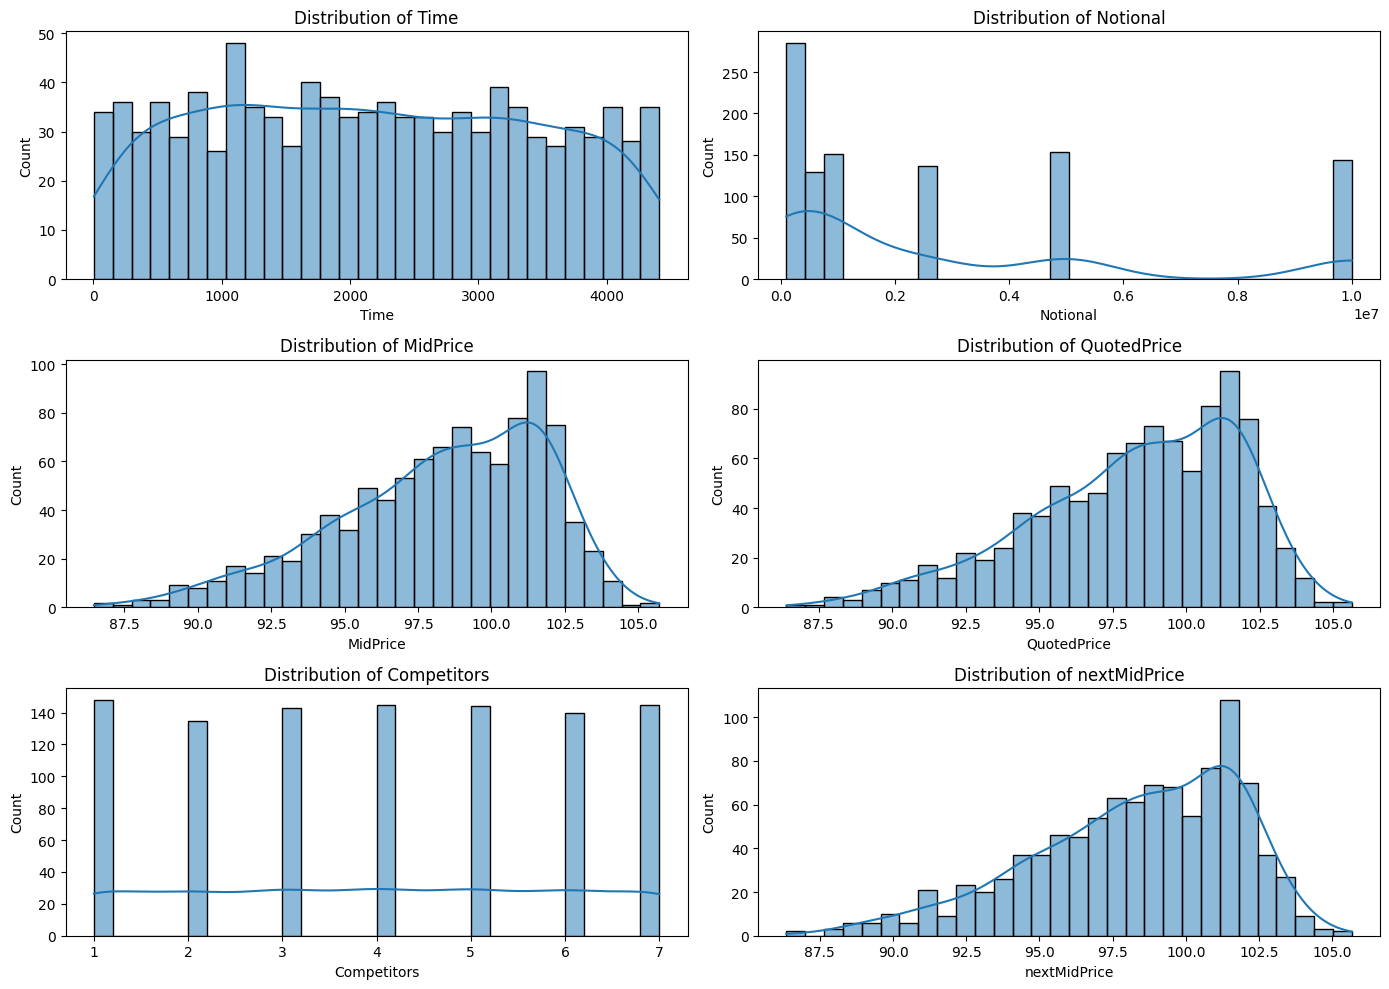

In [9]:
numeric_features = ['Time', 'Notional', 'MidPrice', 'QuotedPrice', 'Competitors', 'nextMidPrice']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

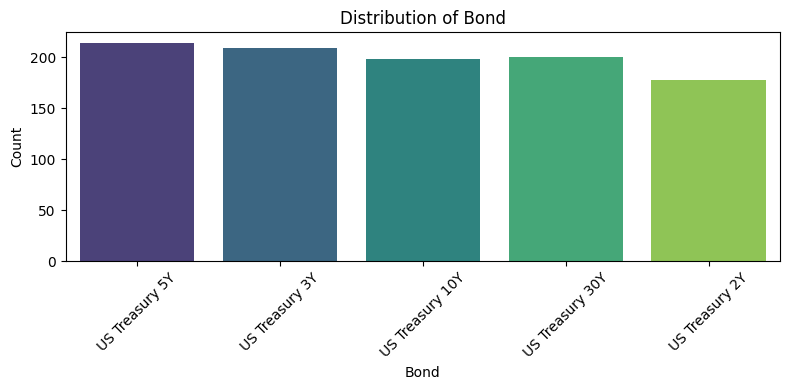

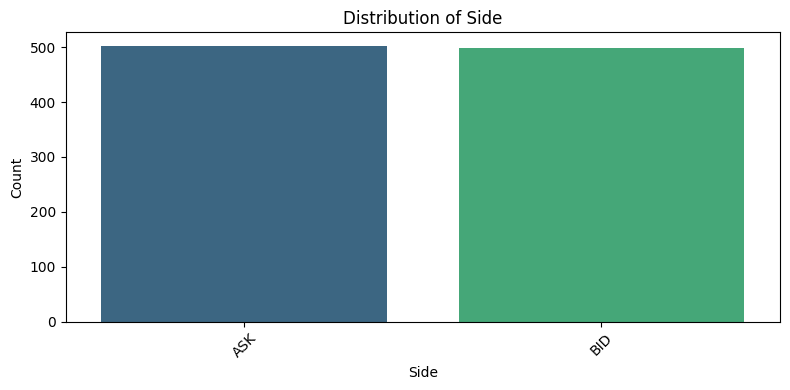

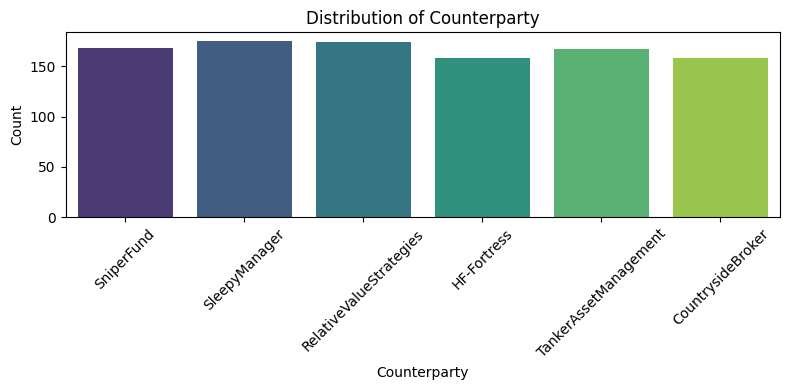

In [10]:
categorical_columns = ['Bond', 'Side', 'Counterparty']

# Create visualizations for each categorical column
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Feature Engineering: Create potential new features for modelling

In [46]:
def feature_engineering(df):
  df = df.copy()

  # os df does not have Traded column
  if 'Traded' in df.columns:
    df['Traded'] = df['Traded'].map({'MISSED': 0, 'DONE': 1})

  df['AbsPriceDiff'] = abs(df['QuotedPrice'] - df['MidPrice'])

  df['PriceDiff'] = df['QuotedPrice'] - df['MidPrice']

  # Create 'signed_distance' feature (side-dependent deviation in basis points)

  df['signed_distance'] = df.apply(
      lambda x: (x['QuotedPrice'] - x['MidPrice']) / x['MidPrice'] * 10000 if x['Side'] == 'ASK'
      else (x['MidPrice'] - x['QuotedPrice']) / x['MidPrice'] * 10000,
      axis=1
  )

  df['LowCompetition'] = (df['Competitors'] < 4).astype(int)

  df['HighCompetition'] = (df['Competitors'] > 4).astype(int)

  df['LargeNotional'] = (df['Notional'] > 5.500000e+06).astype(int)

  df['SmallNotional'] = (df['Notional'] < 4.000000e+06).astype(int)

  if 'nextMidPrice' in df.columns:
    df['AbsPriceDiff_next'] = abs(df['QuotedPrice'] - df['nextMidPrice'])

    df['PriceDiff_next'] = df['QuotedPrice'] - df['nextMidPrice']

    # Create 'signed_distance' feature (side-dependent deviation in basis points)

    df['signed_distance_next'] = df.apply(
        lambda x: (x['QuotedPrice'] - x['nextMidPrice']) / x['nextMidPrice'] * 10000 if x['Side'] == 'ASK'
        else (x['nextMidPrice'] - x['QuotedPrice']) / x['nextMidPrice'] * 10000,
        axis=1
    )

  # Encode categorical columns
  df = pd.get_dummies(df, columns=['Side', 'Counterparty', 'Bond'], drop_first=True)

  return df

In [47]:
df_featured = feature_engineering(df)

When Low competition, equal chance of DONE or MISSED

When High competition, most trades MISSED

When Small Notional, equal chance

When Large Notional, equal chance

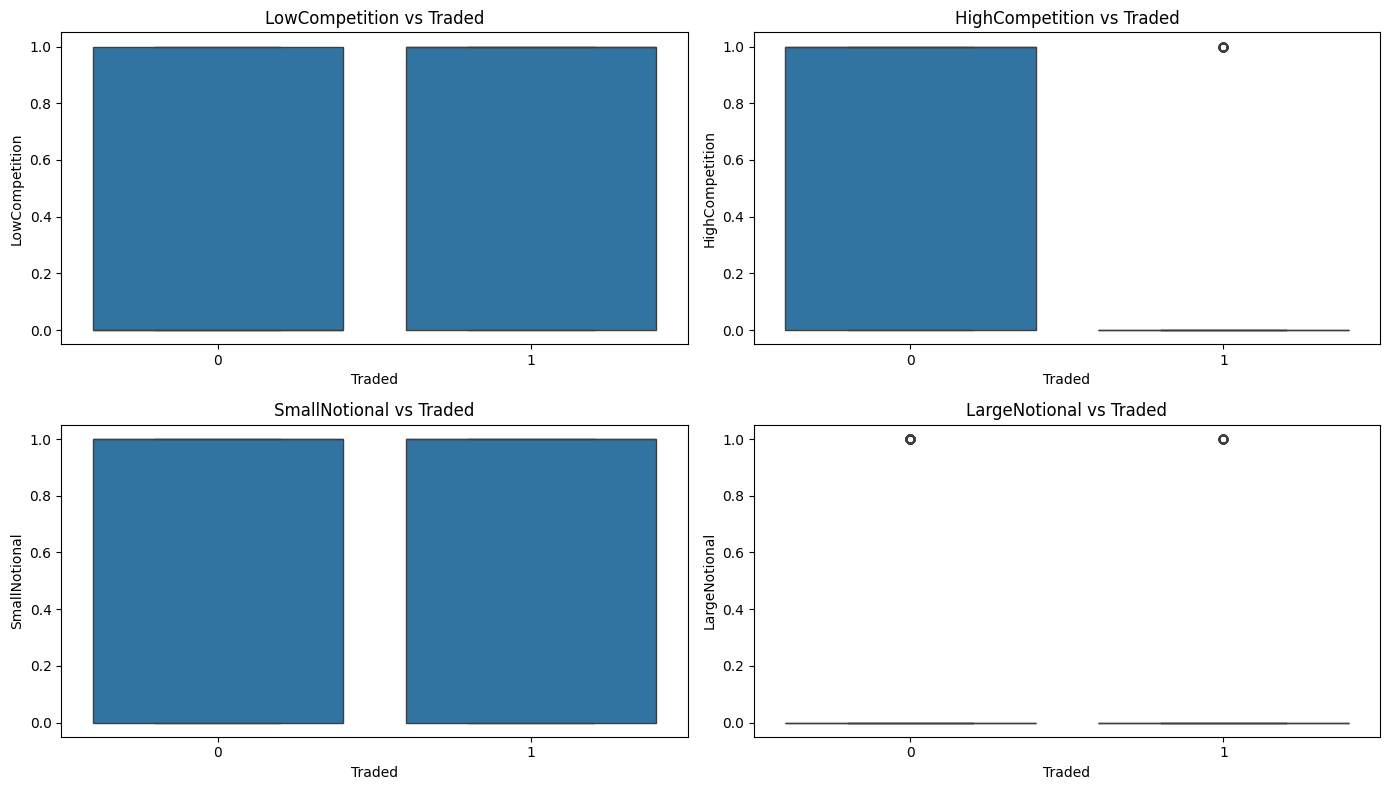

In [48]:
# Plot box plots of selected features against the target variable 'Executed'
plt.figure(figsize=(14, 8))
# Box plot for LowCompetition vs Traded
plt.subplot(2, 2, 1)
sns.boxplot(x='Traded', y='LowCompetition', data=df_featured)
plt.title('LowCompetition vs Traded')

# Box plot for LargeNotional vs Traded
plt.subplot(2, 2, 2)
sns.boxplot(x='Traded', y='HighCompetition', data=df_featured)
plt.title('HighCompetition vs Traded')

# Box plot for SmallNotional vs Traded
plt.subplot(2, 2, 3)
sns.boxplot(x='Traded', y='SmallNotional', data=df_featured)
plt.title('SmallNotional vs Traded')

# Box plot for HighCompetition vs Traded
plt.subplot(2, 2, 4)
sns.boxplot(x='Traded', y='LargeNotional', data=df_featured)
plt.title('LargeNotional vs Traded')


plt.tight_layout()
plt.show()

Signed_distance: if ASK, quoted-mid, if BID, mid-quoted

For DONE trade: signed_distance tend to be smaller or even negative, ask < mid or bid > mid

For MISSED trade: signed distance tend to be positive, ask > mid or bid < mid

Abs_distance:DONE trades on average is closer to nextMid

Some DONE trades have negative signed_distance from nextMid, DONE but negative PNL expected

Text(0.5, 1.0, 'signed_distance vs Traded')

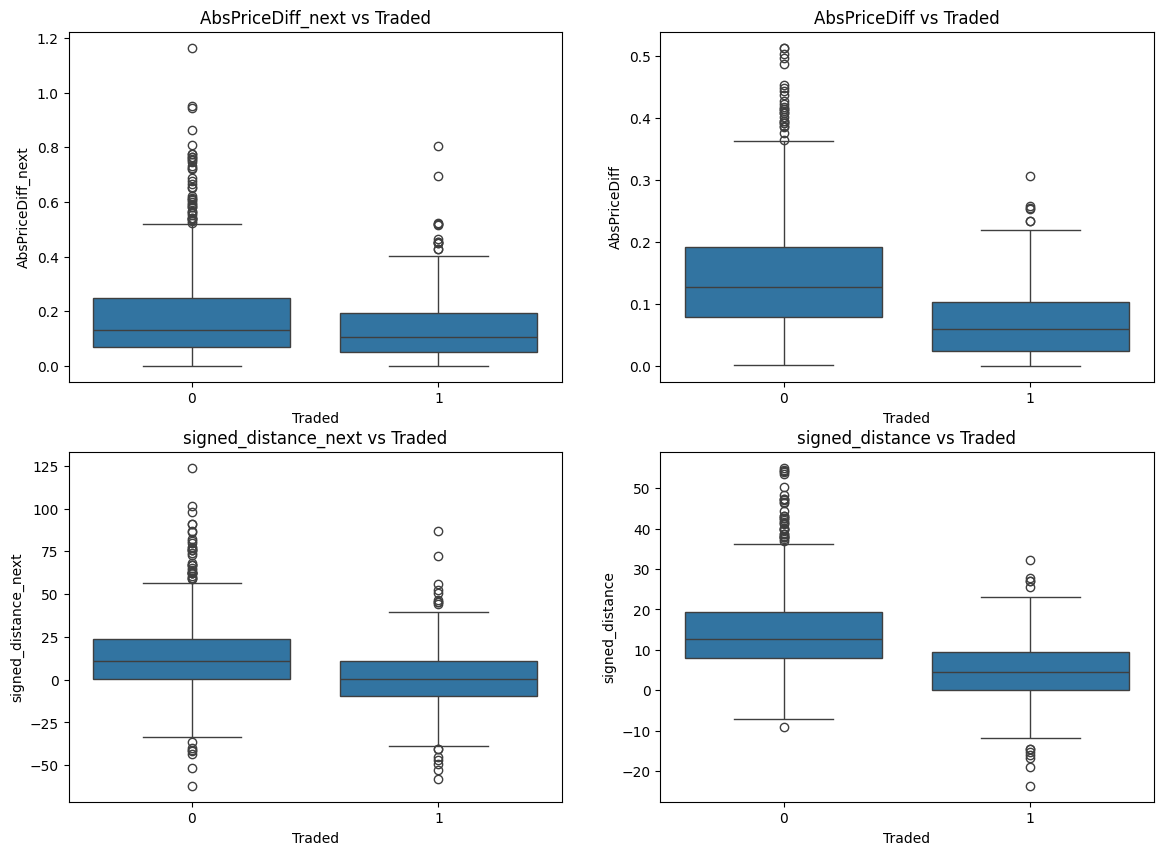

In [35]:
# Plot box plots of selected features against the target variable 'Executed'
plt.figure(figsize=(14, 10))

# Box plot for MidPrice vs Traded
plt.subplot(2, 2, 1)
sns.boxplot(x='Traded', y='AbsPriceDiff_next', data=df_featured)
plt.title('AbsPriceDiff_next vs Traded')

# Box plot for MidPrice vs Traded
plt.subplot(2, 2, 2)
sns.boxplot(x='Traded', y='AbsPriceDiff', data=df_featured)
plt.title('AbsPriceDiff vs Traded')

# Box plot for PriceDiff vs Traded
plt.subplot(2, 2, 3)
sns.boxplot(x='Traded', y='signed_distance_next', data=df_featured)
plt.title('signed_distance_next vs Traded')

# Box plot for PriceDiff vs Traded
plt.subplot(2, 2, 4)
sns.boxplot(x='Traded', y='signed_distance', data=df_featured)
plt.title('signed_distance vs Traded')



In [64]:
df_featured.columns

Index(['Time', 'Notional', 'MidPrice', 'QuotedPrice', 'Competitors', 'Traded',
       'nextMidPrice', 'AbsPriceDiff', 'PriceDiff', 'signed_distance',
       'LowCompetition', 'HighCompetition', 'LargeNotional', 'SmallNotional',
       'AbsPriceDiff_next', 'PriceDiff_next', 'signed_distance_next',
       'Side_BID', 'Counterparty_HF-Fortress',
       'Counterparty_RelativeValueStrategies', 'Counterparty_SleepyManager',
       'Counterparty_SniperFund', 'Counterparty_TankerAssetManagement',
       'Bond_US Treasury 2Y', 'Bond_US Treasury 30Y', 'Bond_US Treasury 3Y',
       'Bond_US Treasury 5Y'],
      dtype='object')

Decide to drop uncorrelated features based on plots

In [68]:
df_featured = df_featured.drop(columns=['Time', 'MidPrice', 'PriceDiff', 'LowCompetition', 'LargeNotional', 'SmallNotional',
                      'PriceDiff_next', 'nextMidPrice'])

In [69]:
from sklearn.feature_selection import RFE

In [72]:
df_featured.columns

Index(['Notional', 'QuotedPrice', 'Competitors', 'Traded', 'AbsPriceDiff',
       'signed_distance', 'HighCompetition', 'AbsPriceDiff_next',
       'signed_distance_next', 'Side_BID', 'Counterparty_HF-Fortress',
       'Counterparty_RelativeValueStrategies', 'Counterparty_SleepyManager',
       'Counterparty_SniperFund', 'Counterparty_TankerAssetManagement',
       'Bond_US Treasury 2Y', 'Bond_US Treasury 30Y', 'Bond_US Treasury 3Y',
       'Bond_US Treasury 5Y'],
      dtype='object')

In [97]:
# Define features and target
X = df_featured.drop(columns=['Traded'])  # Features
y = df_featured['Traded']  # Target

# Split the data (optional, for training and testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model
log_reg = LogisticRegression(solver='liblinear')

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=log_reg, n_features_to_select=6)  # Adjust the number of features
rfe.fit(X_train, y_train)

# Results
print("Selected Features:", X_train.columns[rfe.support_].tolist())
print("Feature Ranking:", dict(zip(X_train.columns, rfe.ranking_)))

# Apply RFE to the original dataset
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Selected Features: ['Notional', 'QuotedPrice', 'Competitors', 'signed_distance', 'HighCompetition', 'signed_distance_next']
Feature Ranking: {'Notional': 1, 'QuotedPrice': 1, 'Competitors': 1, 'signed_distance': 1, 'HighCompetition': 1, 'signed_distance_next': 1, 'Side_BID': 2, 'Counterparty_HF-Fortress': 8, 'Counterparty_RelativeValueStrategies': 10, 'Counterparty_SleepyManager': 11, 'Counterparty_SniperFund': 5, 'Counterparty_TankerAssetManagement': 6, 'Bond_US Treasury 2Y': 7, 'Bond_US Treasury 30Y': 4, 'Bond_US Treasury 3Y': 3, 'Bond_US Treasury 5Y': 9}


Decide to drop less-important features by RFE results

In [76]:
df_featured = df_featured.drop(columns = ['AbsPriceDiff', 'AbsPriceDiff_next'])

Columns need need to be engineered or get_dummies:

Signed_distance, HighCompetition, signed_distance_next needed;

Time, MidPrice, nextMidPrice removed;

Bond, Counterparty , and Side dummied

In [81]:
df_featured.columns

Index(['Notional', 'QuotedPrice', 'Competitors', 'Traded', 'signed_distance',
       'HighCompetition', 'signed_distance_next', 'Side_BID',
       'Counterparty_HF-Fortress', 'Counterparty_RelativeValueStrategies',
       'Counterparty_SleepyManager', 'Counterparty_SniperFund',
       'Counterparty_TankerAssetManagement', 'Bond_US Treasury 2Y',
       'Bond_US Treasury 30Y', 'Bond_US Treasury 3Y', 'Bond_US Treasury 5Y'],
      dtype='object')

In [98]:
os = pd.read_csv("/content/drive/MyDrive/My Projects/FX/os.csv")

In [99]:
os_featured = feature_engineering(os)

OS data has less small notional trade;

has more low competition trade;

closer distance from mid

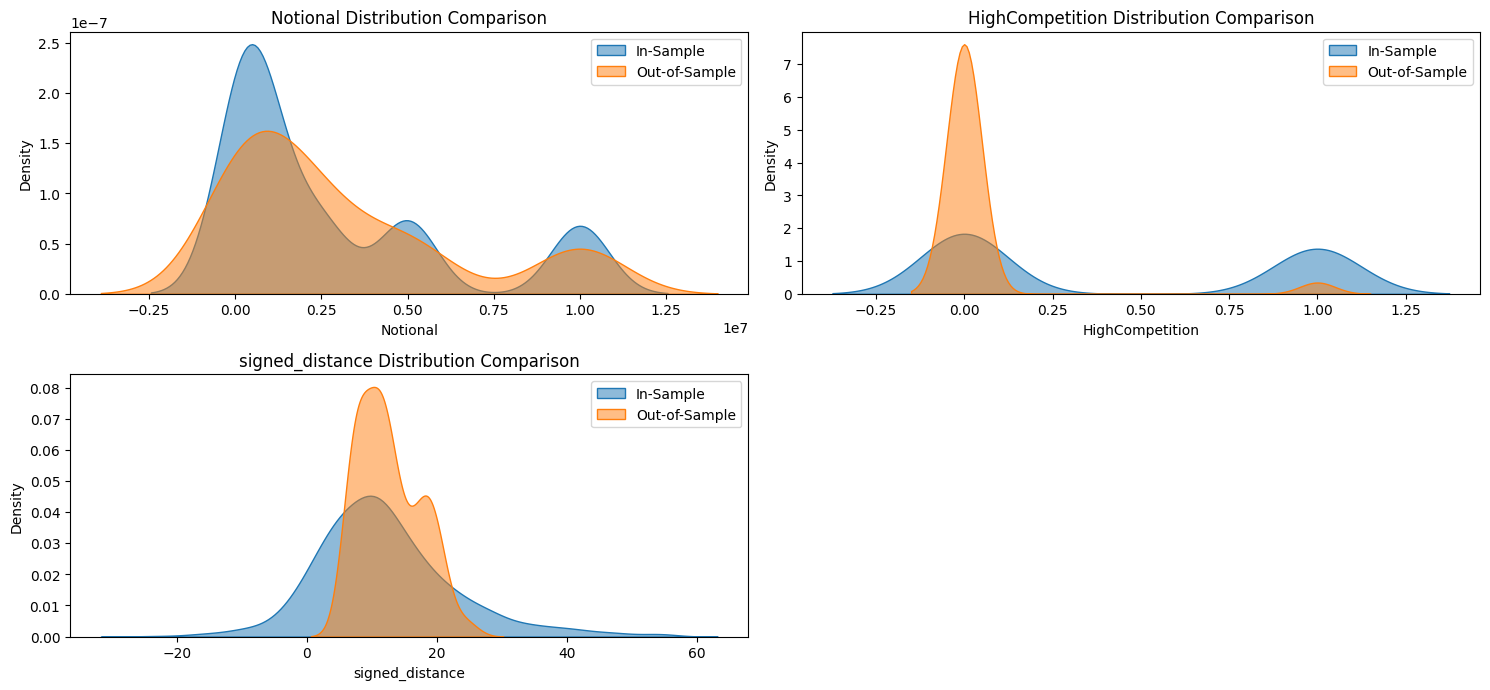

In [101]:
# Select features to compare between in-sample and out-of-sample data
features_to_compare = ['Notional', 'HighCompetition', 'signed_distance']

# Plot distributions for each feature in both in-sample and out-of-sample data
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_compare, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(df_featured[feature], label="In-Sample", fill=True, alpha=0.5)
    sns.kdeplot(os_featured[feature], label="Out-of-Sample", fill=True, alpha=0.5)
    plt.title(f'{feature} Distribution Comparison')
    plt.legend()
plt.tight_layout()
plt.show()